### ====================================================
### Evaluation and Error Analysis
#### Analyze the performance of the fine-tuned RoBERTa model.
#### ====================================================


In [ ]:

# Libraries 
import os
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_from_disk,Dataset
from scipy.special import softmax


torch.manual_seed(42)
np.random.seed(42)

# Model
MODEL_NAME = "roberta-base"

# Paths
path = "C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining"
os.chdir(path)

# Tokenizer
tokenized_dir = f"{path}/tokenized/{MODEL_NAME.replace('/', '_')}_maxlen105"

# Fine-tuned model directory
finetuned_dir = "./models/roberta_finetuned"

# Test data set path
test_path = f"{path}/data/gun_control_test.csv"


c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load Model, Tokenizer and Test Dataset
tokenizer = AutoTokenizer.from_pretrained(finetuned_dir)
model = AutoModelForSequenceClassification.from_pretrained(finetuned_dir)
print(f"Model and tokenizer loaded from: {finetuned_dir}")

Model and tokenizer loaded from: ./models/roberta_finetuned


In [3]:
# Load and prepare test dataset
df_test = pd.read_csv(test_path)
print(f"Test dataset loaded. Shape: {df_test.shape}")

# Encode labels (Same as training!)
label2id = {"oppose": 0, "support": 1}
id2label = {0: "oppose", 1: "support"}
df_test["label"] = df_test["stance"].map(label2id)
df_test.head()

Test dataset loaded. Shape: (150, 6)


,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label
0,1246096866942607362,https://t.co/BM256CPRNF,Seen on my walk. DTSS gun shop is open for bus...,support,yes,test,1
1,1321259279500906496,https://t.co/c6tG93Gw8z,As a responsible gun owner I agree: Making go...,oppose,no,test,0
2,1239679202531532802,https://t.co/XQxGOL3Vd7,Our Yolo County @MomsDemand group has been for...,support,no,test,1
3,1242599596838146048,https://t.co/asY6rqD4O7,PA Governor Pivots: Gun Dealers 'Life Sustaini...,oppose,no,test,0
4,1237439219544371200,https://t.co/NeNcftOadg,Gun Control Costs Lives in Ohio https://t.co/N...,oppose,yes,test,0


In [4]:
#Tokenize Test Dataset
def tokenize_function(examples):
    return tokenizer(examples["tweet_text"],padding="max_length",truncation=True,max_length=105)

test_dataset = Dataset.from_pandas(df_test[["tweet_text", "label"]])
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

print(test_dataset)

Map: 100%|██████████| 150/150 [00:00<00:00, 1621.81 examples/s]

Dataset({
    features: ['tweet_text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 150
})


In [5]:
# Evaluate model on test set
trainer = Trainer(model=model, tokenizer=tokenizer)
predictions = trainer.predict(test_dataset)

#Predictions
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids


#Confidence
logits = predictions.predictions 
probs = softmax(logits, axis=1) 
pred_confidence = probs.max(axis=1) 

#We add it to our test dataset
df_test["pred_label"] = preds
df_test["predicted_label"] = df_test["pred_label"].map(id2label)
df_test["predicted_confidence"] = pred_confidence


C:\Users\diego\AppData\Local\Temp\ipykernel_32604\1219689180.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)
c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [6]:
# Metrics
acc = accuracy_score(labels, preds)
prec, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")

print("Evaluation Metrics on Test Set: ")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(labels, preds, target_names=["oppose", "support"]))


Evaluation Metrics on Test Set: 
Accuracy:  0.8267
Precision: 0.8421
Recall:    0.8267
F1-Score:  0.8210

Detailed Classification Report:
              precision    recall  f1-score   support

      oppose       0.91      0.66      0.77        65
     support       0.79      0.95      0.86        85

    accuracy                           0.83       150
   macro avg       0.85      0.81      0.81       150
weighted avg       0.84      0.83      0.82       150



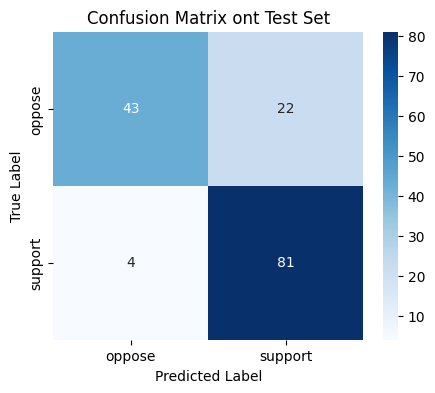

In [7]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[0], id2label[1]],
            yticklabels=[id2label[0], id2label[1]])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix ont Test Set')
plt.show()

In [8]:
#Misclassifications
df_errors = df_test[df_test["label"] != df_test["pred_label"]].copy()
print(f"Misclassified samples: {len(df_errors)} / {len(df_test)}")

# Some Examples
df_errors[["tweet_text","stance","label","pred_label"]].head()

Misclassified samples: 26 / 150


,tweet_text,stance,label,pred_label
10,"H.R. 5717 and S.3254, the Gun Violence Prevent...",oppose,0,1
13,#SanDiego @MomsDemand down at #LaJolla Shores ...,oppose,0,1
21,#SEL is our cure to #endgunviolence! True rese...,oppose,0,1
25,Gun control is working well. Just need a few m...,support,1,0
31,Two years ago we were just high schoolers dema...,oppose,0,1


In [9]:

# Confidence analysis
# We will show the most uncertain and most confidently wrong cases

# Most uncertain predictions (lowest max confidence)
uncertain_df = df_test.copy()
uncertain_df["max_conf"] = df_test["predicted_confidence"]
uncertain_df = uncertain_df.sort_values("max_conf", ascending=True)
print("\nTop 10 most uncertain predictions:")
display(uncertain_df.head(10)[["tweet_text","stance","predicted_label","predicted_confidence"]])

# Most confidently wrong (high confidence but mistakely predicted)
threshold = 0.9
confident_wrong = df_errors[df_errors["predicted_confidence"] >= threshold].sort_values("predicted_confidence", ascending=False)
print(f"\nNumber of confidently wrong predictions (conf >= {threshold}): {len(confident_wrong)}")
if len(confident_wrong) > 0:
    display(confident_wrong.head(20)[["tweet_text","stance","predicted_label","predicted_confidence"]])
else:
    print("No very confident wrong predictions found (>= {threshold}).")



Top 10 most uncertain predictions:


,tweet_text,stance,predicted_label,predicted_confidence
51,"After a few cocktails one night, I got into it...",support,support,0.525251
1,As a responsible gun owner I agree: Making go...,oppose,oppose,0.538225
106,You could find yourself unable to have contact...,oppose,oppose,0.567533
34,Hunting is unnecessary you can by your meat at...,support,support,0.643353
74,The Sig Sauer P320 X5 Legion... a great compet...,oppose,support,0.658659
54,I’m a flaming liberal. I’m a gun owner but don...,oppose,oppose,0.696107
132,"Liar!\n\nEven on the National Stage, bought an...",oppose,support,0.696497
110,The US' inaction on gun control and the green ...,support,support,0.733109
146,"When you're cleaning your firearm, don't forge...",oppose,oppose,0.800962
109,Of the many ridiculous things in Senator Warre...,oppose,oppose,0.816570



Number of confidently wrong predictions (conf >= 0.9): 21


,tweet_text,stance,predicted_label,predicted_confidence
31,Two years ago we were just high schoolers dema...,oppose,support,0.996870
90,Gov. Ralph 'Coonman' Northam proud to sign a s...,oppose,support,0.996830
113,"15,292 people were killed from gun wounds in t...",oppose,support,0.996381
35,Women are five times more likely to be killed ...,oppose,support,0.996356
13,#SanDiego @MomsDemand down at #LaJolla Shores ...,oppose,support,0.995987
75,WA state will have the nation's 1st Office of ...,oppose,support,0.995601
134,We know people are scared and stressed during ...,oppose,support,0.995307
41,"With schools closed, opportunities for kids to...",oppose,support,0.995123
139,#DOJProjectGuardian is another example of the ...,oppose,support,0.994777
21,#SEL is our cure to #endgunviolence! True rese...,oppose,support,0.993507


In [10]:
# Save predictions to disk for later analysis
results_dir = os.path.join(path, "results")
os.makedirs(results_dir, exist_ok=True)
df_test.to_csv(os.path.join(results_dir, "test_predictions_with_confidence.csv"), index=False)
print(f"\nSaved test predictions (with confidence) to: {results_dir}/test_predictions_with_confidence.csv")


Saved test predictions (with confidence) to: C:/Users/diego/Desktop/multimodal-argmining\results/test_predictions_with_confidence.csv
